# Medical Image Analysis Project: Pneumonia Detection
## With Advanced Preprocessing Pipeline

### Overview
In this capstone project, you will apply the deep learning techniques learned in this course to a real-world medical imaging problem: **Pneumonia Detection from Chest X-Rays**.

Specifically, you will work with the **PneumoniaMNIST** dataset, a binary classification subset of the MedMNIST collection. Your goal is to build a robust classifier that distinguishes between 'Normal' and 'Pneumonia' cases.

Unlike previous tutorials where models were prescribed, **you interpret the data and choose the model architecture** best suited for the task. You will be evaluated not just on accuracy, but on your design choices, rigorous evaluation, and interpretability of results.

### Preprocessing Enhancements
This notebook integrates the advanced preprocessing pipeline from `preprocessing.py`, which includes:
- **Data Augmentation**: Random flips, rotations, affine transforms, color jitter
- **Normalization**: Dataset-specific mean/std normalization
- **Class Imbalance Handling**: Weighted sampling, Focal Loss
- **CLAHE**: Contrast Limited Adaptive Histogram Equalization
- **Mixup/CutMix**: Advanced regularization augmentations
- **Test-Time Augmentation (TTA)**: More robust test predictions

## 1. Setup and Data Loading
First, we install and load the necessary libraries. We rely on `medmnist` for data retrieval and `torch` for modeling.

In [4]:
!pip install opencv-python

   ---------------------------------------- 0.0/40.2 MB ? eta -:--:--
   ------ --------------------------------- 6.6/40.2 MB 33.6 MB/s eta 0:00:02
   ------------- -------------------------- 13.9/40.2 MB 34.9 MB/s eta 0:00:01
   ------------------- -------------------- 19.9/40.2 MB 33.1 MB/s eta 0:00:01
   -------------------------- ------------- 26.2/40.2 MB 32.0 MB/s eta 0:00:01
   ----------------------------- ---------- 29.6/40.2 MB 28.9 MB/s eta 0:00:01
   --------------------------------- ------ 33.3/40.2 MB 27.1 MB/s eta 0:00:01
   -------------------------------------- - 38.5/40.2 MB 26.6 MB/s eta 0:00:01
   ---------------------------------------  40.1/40.2 MB 26.6 MB/s eta 0:00:01
   ---------------------------------------- 40.2/40.2 MB 24.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# !pip install medmnist # Uncomment if running in Colab

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import numpy as np

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.__file__}")

MedMNIST v3.0.2 @ c:\Users\ayman\AppData\Local\Programs\Python\Python312\Lib\site-packages\medmnist\__init__.py


### Import Preprocessing Pipeline
We import our custom preprocessing module that provides all the data processing utilities.

In [6]:
# Import the preprocessing pipeline
from preprocessing import (
    get_train_transform,
    get_val_transform,
    get_weighted_sampler,
    create_weighted_dataloader,
    get_class_weights,
    FocalLoss,
    WeightedCrossEntropyLoss,
    mixup_data,
    mixup_criterion,
    TestTimeAugmentation,
    print_preprocessing_info
)

# Print available preprocessing options
print_preprocessing_info()

Preprocessing Pipeline for PneumoniaMNIST

Available Transforms:
  - get_train_transform(use_augmentation=True)
  - get_val_transform()
  - get_train_transform_with_clahe(use_augmentation=True)

Class Imbalance Handling:
  - get_weighted_sampler(dataset)
  - create_weighted_dataloader(dataset, batch_size)
  - WeightedCrossEntropyLoss(class_weights)
  - FocalLoss(alpha=1.0, gamma=2.0)

Augmentation:
  - mixup_data(x, y, alpha=0.2)
  - cutmix_data(x, y, alpha=1.0)
  - TestTimeAugmentation(model, device, n_augments=8)

Radiomic Features:
  - extract_radiomic_features(img)
  - extract_batch_features(images)

Convenience Functions:
  - setup_preprocessing_pipeline(...)


### Data Understanding
We use **PneumoniaMNIST**, which contains cropped chest X-ray images. The task is binary classification: **0 (Normal)** vs **1 (Pneumonia)**.

In [7]:
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Use preprocessing pipeline transforms instead of basic transform
train_transform = get_train_transform(use_augmentation=True)
val_transform = get_val_transform()

print("Using Advanced Preprocessing Pipeline:")
print(f"  Train Transform: Augmentation + Normalization")
print(f"  Val/Test Transform: Normalization only")

# Load datasets with appropriate transforms
train_dataset = DataClass(split='train', transform=train_transform, download=download)
val_dataset = DataClass(split='val', transform=val_transform, download=download)
test_dataset = DataClass(split='test', transform=val_transform, download=download)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Using Advanced Preprocessing Pipeline:
  Train Transform: Augmentation + Normalization
  Val/Test Transform: Normalization only
Using downloaded and verified file: C:\Users\ayman\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\ayman\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\ayman\.medmnist\pneumoniamnist.npz

Train samples: 4708
Val samples: 524
Test samples: 624


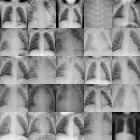

In [8]:
# Visualization of samples (need dataset without transform for visual)
viz_dataset = DataClass(split='train', transform=transforms.ToTensor(), download=False)
viz_dataset.montage(length=5)

### Class Distribution Analysis
Before proceeding, it is crucial to understand if our classes are balanced. Imbalanced datasets can lead to biased models that predict the majority class. Check the counts below.

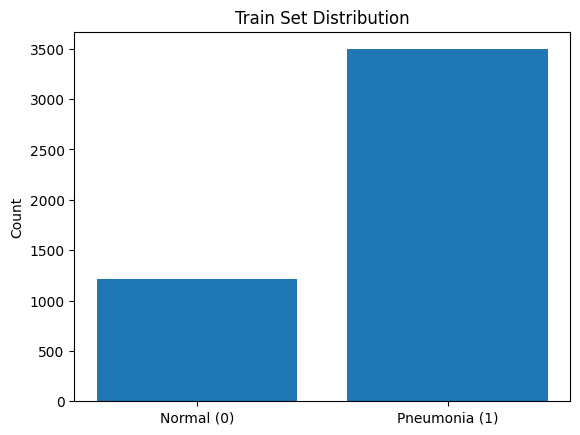

Counts: {'Normal': np.int64(1214), 'Pneumonia': np.int64(3494)}

Class Imbalance Ratio: 2.88x more Pneumonia samples


In [9]:
# Analyze Class Distribution
def plot_class_distribution(dataset, title='Class Distribution'):
    targets = [y for _, y in dataset]
    targets = np.array(targets).squeeze()
    unique, counts = np.unique(targets, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique, ['Normal (0)', 'Pneumonia (1)'])
    plt.title(title)
    plt.ylabel('Count')
    plt.show()
    print(f"Counts: {dict(zip(['Normal', 'Pneumonia'], counts))}")
    print(f"\nClass Imbalance Ratio: {counts[1]/counts[0]:.2f}x more Pneumonia samples")

plot_class_distribution(train_dataset, 'Train Set Distribution')

## 2. Project Requirements

You are required to complete the following tasks to structure your project. Please document your process clearly in markdown cells alongside your code.

### 1. Define the Problem Statement
- Clearly state the medical problem you are solving (Pneumonia Detection).
- Explain why this is important and what the clinical impact of an automated solution could be.
- Describe the dataset characteristics (size, class balance, image type).

### 2. Choose an Architecture / Approach
- Select a modeling approach. You may choose:
    - One of the architectures explored in `Building_Models.ipynb` (e.g., Simple CNN, Radiomics-based RF, Contrastive Learning).
    - An alternative architecture (e.g., ResNet, DenseNet, Vision Transformer) if you wish to explore further.
- **Justify your choice**: Why is this model suitable for this specific task and dataset?

### 3. Hyperparameter Tuning
- Experiment with key hyperparameters to optimize performance.
- Consider tuning: Learning rate, Batch size, Number of epochs, Optimizer type (Adam vs SGD), Dropout rate, etc.
- Document your tuning process and the final set of hyperparameters selected.

### 4. Training Analysis
- Implement a training loop that tracks performance on both Training and Validation sets.
- **Produce a Training Loss Curve**: Plot training and validation loss over epochs to diagnose overfitting or underfitting.

### 5. Evaluation and Metrics
- Evaluate your best model on the **Test Set**.
- **Produce an ROC Curve**: Plot the Receiver Operating Characteristic curve.
- Report key metrics:
    - **AUC (Area Under Curve)**
    - **F1-Score**
    - **Sensitivity (Recall)** and **Specificity**

### 6. Extensions, Limitations, and Implications
- **Extensions**: How could this model be improved further? (e.g., more data, ensemble methods, external validation).
- **Limitations**: What are the current weaknesses of your solution? (e.g., class imbalance handling, robustness to noise, generalization).
- **Implications**: Discuss the ethical and practical implications of deploying this AI model in a real clinical setting (e.g., bias, explainability, doctor-AI collaboration).

## 3. Student Workspace
Implement your solution below.

In [10]:
# Your code starts here
# Good luck!

## Prepare Dataset with Preprocessing Pipeline

In [11]:
# ========================================
# 2. Prepare Dataset with Preprocessing
# ========================================

# Use the PneumoniaMNIST dataset (already binary: 0=Normal, 1=Pneumonia)
from medmnist import PneumoniaMNIST

# Use preprocessing pipeline transforms
train_transform = get_train_transform(use_augmentation=True)
val_transform = get_val_transform()

# Load PneumoniaMNIST datasets with preprocessing transforms
train_dataset = PneumoniaMNIST(split='train', transform=train_transform, download=True)
val_dataset = PneumoniaMNIST(split='val', transform=val_transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=val_transform, download=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Calculate class weights for weighted loss
class_weights = get_class_weights(train_dataset)
print(f"\nClass weights: {class_weights}")

# Create weighted sampler for class-balanced training
weighted_sampler = get_weighted_sampler(train_dataset)

# DataLoaders - using weighted sampling for training
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=weighted_sampler,  # Weighted sampling for class balance
    num_workers=0
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\n✅ Datasets and loaders ready with:")
print("  - Data augmentation (flips, rotations, affine, color jitter)")
print("  - Weighted sampling for class balance")
print("  - Normalization (mean=0.5, std=0.5)")

Using downloaded and verified file: C:\Users\ayman\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\ayman\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\ayman\.medmnist\pneumoniamnist.npz
Train samples: 4708
Val samples: 524
Test samples: 624

Class weights: tensor([1.9390, 0.6737])

✅ Datasets and loaders ready with:
  - Data augmentation (flips, rotations, affine, color jitter)
  - Weighted sampling for class balance
  - Normalization (mean=0.5, std=0.5)


Using device: cuda
Using FocalLoss for handling class imbalance

🚀 Training Small CNN with Preprocessing Pipeline...
Epoch 1/5 | Loss: 0.1510
Epoch 2/5 | Loss: 0.1182
Epoch 3/5 | Loss: 0.1175
Epoch 4/5 | Loss: 0.1027
Epoch 5/5 | Loss: 0.1011

📈 Pneumonia Detection - Small 3-Layer CNN Results (With Preprocessing):
              precision    recall  f1-score   support

      Normal     0.6333    0.9744    0.7677       234
   Pneumonia     0.9773    0.6615    0.7890       390

    accuracy                         0.7788       624
   macro avg     0.8053    0.8179    0.7783       624
weighted avg     0.8483    0.7788    0.7810       624

ROC AUC: 0.9493
Precision: 0.9773
Recall (Sensitivity): 0.6615
Specificity: 0.9744
F1 Score: 0.7890


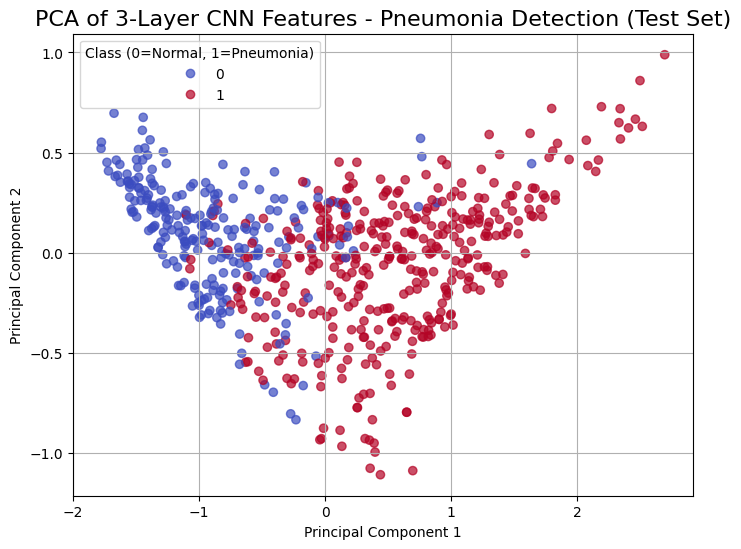

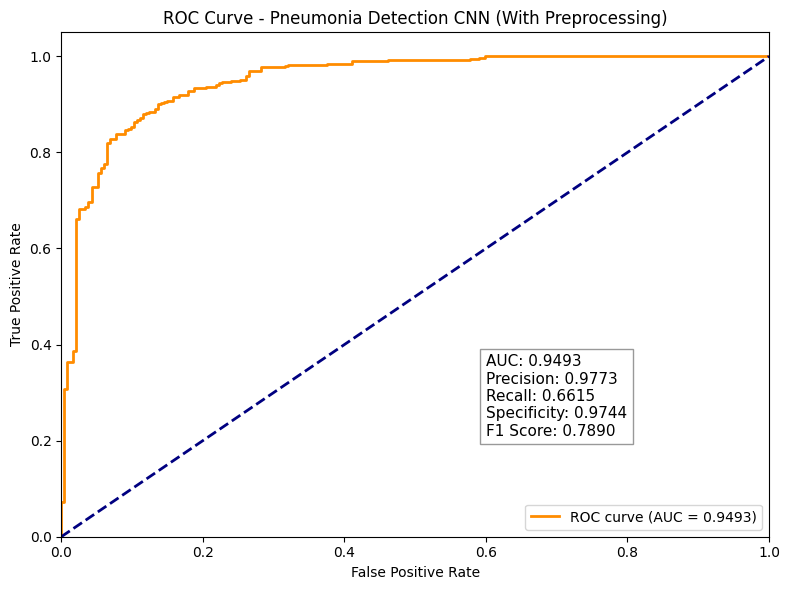

In [13]:
# ========================================
# 4. Small 3-Layer CNN Classifier with Preprocessing
# ========================================

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Import metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, roc_curve
from sklearn.decomposition import PCA

# Define model (1 input channel for grayscale X-ray images)
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 channel for grayscale
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN().to(device)

# Training setup - using FocalLoss for class imbalance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = FocalLoss(alpha=1.0, gamma=2.0)  # Using FocalLoss from preprocessing

print("Using FocalLoss for handling class imbalance")

# Train loop with optional Mixup
def train_model(model, loader, optimizer, criterion, epochs=5, use_mixup=False, mixup_alpha=0.2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)
            
            optimizer.zero_grad()
            
            if use_mixup:
                # Apply Mixup augmentation
                mixed_imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
                outputs = model(mixed_imgs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f}")

print("\n🚀 Training Small CNN with Preprocessing Pipeline...")
train_model(model, train_loader, optimizer, criterion, epochs=5, use_mixup=True)

# Evaluation
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels, all_probs, all_features = [], [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().numpy()  # Squeeze labels to 1D
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:,1]  # Probabilities for class 1 (Pneumonia)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels)
            all_features.append(model.features(imgs).view(imgs.size(0), -1).cpu().numpy())

    return (np.concatenate(all_labels),
            np.concatenate(all_preds),
            np.concatenate(all_probs),
            np.vstack(all_features))

y_true, y_pred, y_probs, test_features = evaluate_model(model, test_loader)

# Metrics
roc_auc = roc_auc_score(y_true, y_probs)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Calculate specificity
tn = np.sum((y_true == 0) & (y_pred == 0))
fp = np.sum((y_true == 0) & (y_pred == 1))
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n📈 Pneumonia Detection - Small 3-Layer CNN Results (With Preprocessing):")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# PCA Visualization
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_features_pca[:,0], test_features_pca[:,1], c=y_true, cmap='coolwarm', alpha=0.7)
plt.title('PCA of 3-Layer CNN Features - Pneumonia Detection (Test Set)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Normal, 1=Pneumonia)")
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Pneumonia Detection CNN (With Preprocessing)')
plt.legend(loc='lower right')

# Add metrics box
metrics_text = (
    f"AUC: {roc_auc:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall: {recall:.4f}\n"
    f"Specificity: {specificity:.4f}\n"
    f"F1 Score: {f1:.4f}"
)
plt.text(0.6, 0.2, metrics_text, fontsize=11, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

Using device: cuda
MedNet Parameters: 3,277,046

🚀 Training MedNet with Advanced Preprocessing...
  - Using weighted sampling for class balance
  - Using FocalLoss for class imbalance
  - Using Mixup augmentation
  - Using data augmentation (flips, rotations, etc.)

Epoch 1/20 | Train Loss: 0.1455 | Val Loss: 0.0764 | LR: 0.000298
Epoch 2/20 | Train Loss: 0.0999 | Val Loss: 0.0741 | LR: 0.000293
Epoch 3/20 | Train Loss: 0.0973 | Val Loss: 0.0664 | LR: 0.000284
Epoch 4/20 | Train Loss: 0.0879 | Val Loss: 0.0857 | LR: 0.000271
Epoch 5/20 | Train Loss: 0.0866 | Val Loss: 0.0595 | LR: 0.000256
Epoch 6/20 | Train Loss: 0.0810 | Val Loss: 0.0665 | LR: 0.000238
Epoch 7/20 | Train Loss: 0.0830 | Val Loss: 0.0493 | LR: 0.000218
Epoch 8/20 | Train Loss: 0.0869 | Val Loss: 0.0746 | LR: 0.000197
Epoch 9/20 | Train Loss: 0.0766 | Val Loss: 0.0713 | LR: 0.000174
Epoch 10/20 | Train Loss: 0.0886 | Val Loss: 0.0806 | LR: 0.000150
Epoch 11/20 | Train Loss: 0.0817 | Val Loss: 0.0684 | LR: 0.000127
Epoch

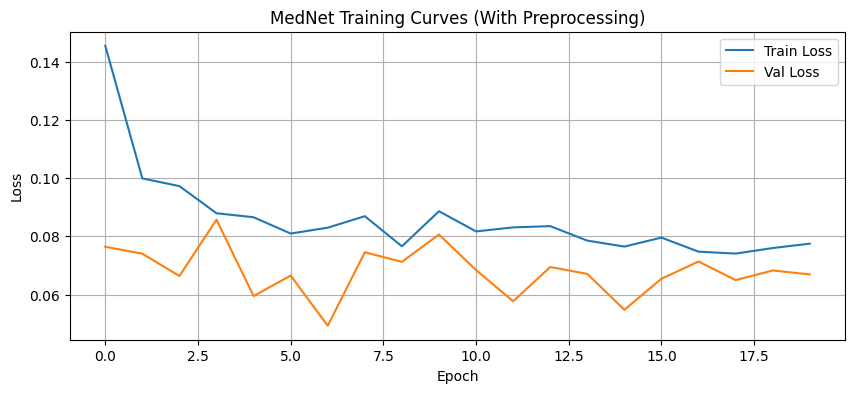


📈 Pneumonia Detection - MedNet Results (With Preprocessing):
              precision    recall  f1-score   support

      Normal     0.8231    0.9145    0.8664       234
   Pneumonia     0.9451    0.8821    0.9125       390

    accuracy                         0.8942       624
   macro avg     0.8841    0.8983    0.8894       624
weighted avg     0.8993    0.8942    0.8952       624

ROC AUC: 0.9589
Precision: 0.9451
Recall (Sensitivity): 0.8821
Specificity: 0.9145
F1 Score: 0.9125


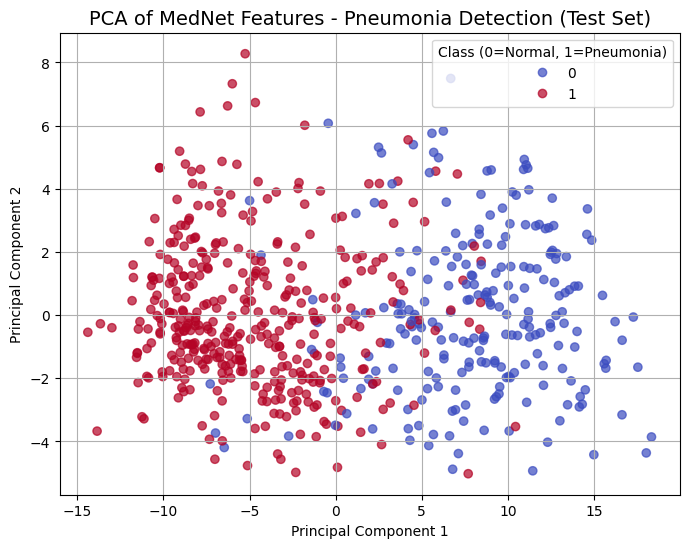

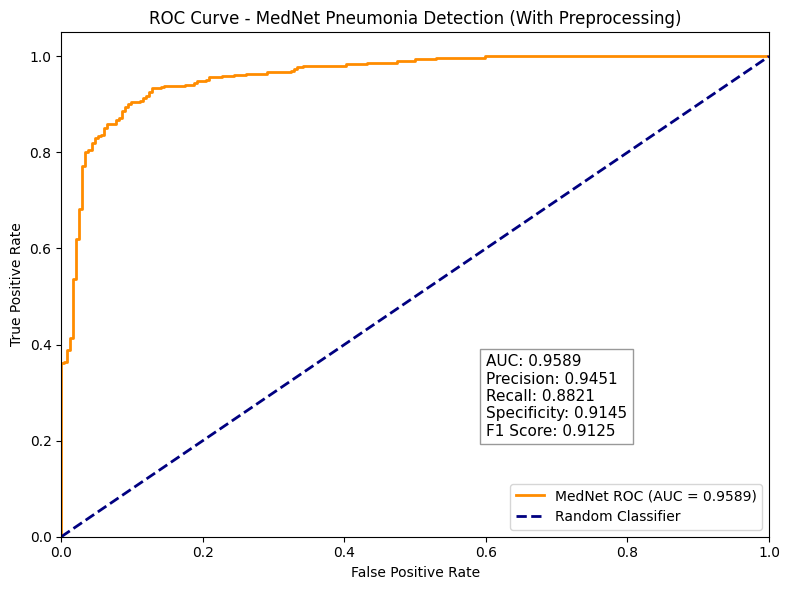

In [14]:
# ========================================
# 5. MedNet Classifier with Preprocessing
# ========================================
# MedNet: Lightweight Attention-Augmented CNN for Medical Image Classification
# Paper: https://www.nature.com/articles/s41598-025-25857-w

# Import the MedNet model and count_parameters from models.py
from models import MedNet, count_parameters

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create MedNet model (1 input channel for grayscale, 2 classes for binary classification)
mednet_model = MedNet(
    in_channels=1,    # Grayscale chest X-rays
    num_classes=2,    # Normal vs Pneumonia
    dropout=0.4
).to(device)

print(f"MedNet Parameters: {count_parameters(mednet_model):,}")

# Training setup - using FocalLoss from preprocessing module
optimizer_mednet = torch.optim.AdamW(
    mednet_model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# Use FocalLoss from preprocessing module for class imbalance
criterion_mednet = FocalLoss(alpha=1, gamma=2)

# Learning rate scheduler (Cosine Annealing as per paper)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_mednet,
    T_max=20,
    eta_min=1e-6
)

# Training loop with validation tracking and optional Mixup
def train_mednet(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=20, use_mixup=True):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)
            
            optimizer.zero_grad()
            
            if use_mixup:
                # Apply Mixup augmentation
                mixed_imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha=0.2)
                outputs = model(mixed_imgs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.squeeze().long().to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    return train_losses, val_losses

# Train MedNet
print("\n🚀 Training MedNet with Advanced Preprocessing...")
print("  - Using weighted sampling for class balance")
print("  - Using FocalLoss for class imbalance")
print("  - Using Mixup augmentation")
print("  - Using data augmentation (flips, rotations, etc.)\n")

train_losses, val_losses = train_mednet(
    mednet_model, train_loader, val_loader,
    optimizer_mednet, criterion_mednet, scheduler,
    epochs=20, use_mixup=True
)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MedNet Training Curves (With Preprocessing)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function for MedNet
def evaluate_mednet(model, loader):
    model.eval()
    all_preds, all_labels, all_probs, all_features = [], [], [], []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().numpy()
            
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for Pneumonia class
            preds = torch.argmax(outputs, dim=1)
            
            # Get features for visualization
            features = model.get_features(imgs)
            
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels)
            all_features.append(features.cpu().numpy())
    
    return (np.concatenate(all_labels),
            np.concatenate(all_preds),
            np.concatenate(all_probs),
            np.vstack(all_features))

# Evaluate on test set
y_true_mednet, y_pred_mednet, y_probs_mednet, test_features_mednet = evaluate_mednet(mednet_model, test_loader)

# Compute metrics
roc_auc_mednet = roc_auc_score(y_true_mednet, y_probs_mednet)
precision_mednet = precision_score(y_true_mednet, y_pred_mednet)
recall_mednet = recall_score(y_true_mednet, y_pred_mednet)
f1_mednet = f1_score(y_true_mednet, y_pred_mednet)

# Calculate specificity
tn = np.sum((y_true_mednet == 0) & (y_pred_mednet == 0))
fp = np.sum((y_true_mednet == 0) & (y_pred_mednet == 1))
specificity_mednet = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n📈 Pneumonia Detection - MedNet Results (With Preprocessing):")
print(classification_report(y_true_mednet, y_pred_mednet, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC: {roc_auc_mednet:.4f}")
print(f"Precision: {precision_mednet:.4f}")
print(f"Recall (Sensitivity): {recall_mednet:.4f}")
print(f"Specificity: {specificity_mednet:.4f}")
print(f"F1 Score: {f1_mednet:.4f}")

# PCA Visualization of MedNet features
pca_mednet = PCA(n_components=2)
test_features_pca_mednet = pca_mednet.fit_transform(test_features_mednet)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_features_pca_mednet[:, 0], test_features_pca_mednet[:, 1],
                      c=y_true_mednet, cmap='coolwarm', alpha=0.7)
plt.title('PCA of MedNet Features - Pneumonia Detection (Test Set)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Normal, 1=Pneumonia)")
plt.grid(True)
plt.show()

# ROC Curve
fpr_mednet, tpr_mednet, _ = roc_curve(y_true_mednet, y_probs_mednet)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mednet, tpr_mednet, color='darkorange', lw=2, label=f'MedNet ROC (AUC = {roc_auc_mednet:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MedNet Pneumonia Detection (With Preprocessing)')
plt.legend(loc='lower right')

# Add metrics box
metrics_text = (
    f"AUC: {roc_auc_mednet:.4f}\n"
    f"Precision: {precision_mednet:.4f}\n"
    f"Recall: {recall_mednet:.4f}\n"
    f"Specificity: {specificity_mednet:.4f}\n"
    f"F1 Score: {f1_mednet:.4f}"
)
plt.text(0.6, 0.2, metrics_text, fontsize=11, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

## Test-Time Augmentation (TTA)
Apply TTA to get more robust predictions by averaging across multiple augmented versions of each test image.

In [15]:
# ========================================
# 6. Evaluate with Test-Time Augmentation
# ========================================

print("\n🔄 Applying Test-Time Augmentation (TTA)...")

# Create TTA object
tta = TestTimeAugmentation(mednet_model, device, n_augments=8)

# Evaluate with TTA
all_preds_tta, all_labels_tta, all_probs_tta = [], [], []

mednet_model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        labels = labels.squeeze().numpy()
        
        # Get TTA predictions
        probs = tta.predict(imgs)
        preds = torch.argmax(probs, dim=1)
        
        all_preds_tta.append(preds.cpu().numpy())
        all_probs_tta.append(probs[:, 1].cpu().numpy())  # Pneumonia probability
        all_labels_tta.append(labels)

y_true_tta = np.concatenate(all_labels_tta)
y_pred_tta = np.concatenate(all_preds_tta)
y_probs_tta = np.concatenate(all_probs_tta)

# Compute TTA metrics
roc_auc_tta = roc_auc_score(y_true_tta, y_probs_tta)
precision_tta = precision_score(y_true_tta, y_pred_tta)
recall_tta = recall_score(y_true_tta, y_pred_tta)
f1_tta = f1_score(y_true_tta, y_pred_tta)

tn_tta = np.sum((y_true_tta == 0) & (y_pred_tta == 0))
fp_tta = np.sum((y_true_tta == 0) & (y_pred_tta == 1))
specificity_tta = tn_tta / (tn_tta + fp_tta) if (tn_tta + fp_tta) > 0 else 0

print("\n📈 Pneumonia Detection - MedNet with TTA Results:")
print(classification_report(y_true_tta, y_pred_tta, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC: {roc_auc_tta:.4f}")
print(f"Precision: {precision_tta:.4f}")
print(f"Recall (Sensitivity): {recall_tta:.4f}")
print(f"Specificity: {specificity_tta:.4f}")
print(f"F1 Score: {f1_tta:.4f}")

# Compare with and without TTA
print("\n📊 Comparison: Standard vs TTA Evaluation")
print(f"{'Metric':<20} {'Without TTA':<15} {'With TTA':<15} {'Improvement':<15}")
print("-" * 65)
print(f"{'ROC AUC':<20} {roc_auc_mednet:<15.4f} {roc_auc_tta:<15.4f} {roc_auc_tta - roc_auc_mednet:+.4f}")
print(f"{'Precision':<20} {precision_mednet:<15.4f} {precision_tta:<15.4f} {precision_tta - precision_mednet:+.4f}")
print(f"{'Recall':<20} {recall_mednet:<15.4f} {recall_tta:<15.4f} {recall_tta - recall_mednet:+.4f}")
print(f"{'Specificity':<20} {specificity_mednet:<15.4f} {specificity_tta:<15.4f} {specificity_tta - specificity_mednet:+.4f}")
print(f"{'F1 Score':<20} {f1_mednet:<15.4f} {f1_tta:<15.4f} {f1_tta - f1_mednet:+.4f}")


🔄 Applying Test-Time Augmentation (TTA)...

📈 Pneumonia Detection - MedNet with TTA Results:
              precision    recall  f1-score   support

      Normal     0.8314    0.9274    0.8768       234
   Pneumonia     0.9532    0.8872    0.9190       390

    accuracy                         0.9022       624
   macro avg     0.8923    0.9073    0.8979       624
weighted avg     0.9075    0.9022    0.9032       624

ROC AUC: 0.9696
Precision: 0.9532
Recall (Sensitivity): 0.8872
Specificity: 0.9274
F1 Score: 0.9190

📊 Comparison: Standard vs TTA Evaluation
Metric               Without TTA     With TTA        Improvement    
-----------------------------------------------------------------
ROC AUC              0.9589          0.9696          +0.0107
Precision            0.9451          0.9532          +0.0081
Recall               0.8821          0.8872          +0.0051
Specificity          0.9145          0.9274          +0.0128
F1 Score             0.9125          0.9190          +0.00